<a href="https://colab.research.google.com/github/jenniferamhajduk/AIML_Playground/blob/main/Custom_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@InProceedings{cimpoi14describing,
	      Author    = {M. Cimpoi and S. Maji and I. Kokkinos and S. Mohamed and and A. Vedaldi},
	      Title     = {Describing Textures in the Wild},
	      Booktitle = {Proceedings of the {IEEE} Conf. on Computer Vision and Pattern Recognition ({CVPR})},
	      Year      = {2014}}

In [259]:
!pip install tqdm
!pip install torchmetrics
!pip install pytorch-ignite

In [260]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torch
from torch import nn
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from ignite.metrics import ConfusionMatrix
from ignite.engine import Engine, Events
from pathlib import Path
import pandas as pd
torch.__version__

'2.1.0+cu121'

In [261]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [262]:
!nvidia-smi

Sun Mar  3 21:31:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              47W / 300W |   7340MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [263]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [264]:
train_data = datasets.DTD(
    root="data",
    split="train",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

test_data = datasets.DTD(
    root="data",
    split="test",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

val_data = datasets.DTD(
    root="data",
    split="val",
    partition=1,
    transform=transform,
    target_transform=None,
    download=True
)

In [265]:
len(train_data), len(test_data), len(val_data)

(1880, 1880, 1880)

In [266]:
image, target = train_data[0]

In [267]:
image, target

(tensor([[[1.0000, 1.0000, 0.9961,  ..., 0.5765, 0.9294, 0.9961],
          [1.0000, 1.0000, 0.9961,  ..., 0.5804, 0.9294, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.5804, 0.9294, 0.9961],
          ...,
          [1.0000, 1.0000, 0.9961,  ..., 0.5804, 0.9294, 0.9961],
          [1.0000, 1.0000, 0.9961,  ..., 0.5804, 0.9294, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.5804, 0.9294, 1.0000]],
 
         [[0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3216],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          ...,
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255],
          [0.9765, 0.3294, 0.0118,  ..., 0.8745, 0.9529, 0.3255]],
 
         [[0.9882, 0.6627, 0.5020,  ..., 0.3804, 0.8863, 0.6549],
          [0.9882, 0.6627, 0.5020,  ..., 0.3804, 0.8863, 0.6549],
          [0.9882, 0.6627, 0.5020,  ...,

In [268]:
image.shape

torch.Size([3, 64, 64])

In [269]:
classes = train_data.classes
classes

['banded',
 'blotchy',
 'braided',
 'bubbly',
 'bumpy',
 'chequered',
 'cobwebbed',
 'cracked',
 'crosshatched',
 'crystalline',
 'dotted',
 'fibrous',
 'flecked',
 'freckled',
 'frilly',
 'gauzy',
 'grid',
 'grooved',
 'honeycombed',
 'interlaced',
 'knitted',
 'lacelike',
 'lined',
 'marbled',
 'matted',
 'meshed',
 'paisley',
 'perforated',
 'pitted',
 'pleated',
 'polka-dotted',
 'porous',
 'potholed',
 'scaly',
 'smeared',
 'spiralled',
 'sprinkled',
 'stained',
 'stratified',
 'striped',
 'studded',
 'swirly',
 'veined',
 'waffled',
 'woven',
 'wrinkled',
 'zigzagged']

In [270]:
len(classes)

47

Text(0.5, 1.0, 'braided')

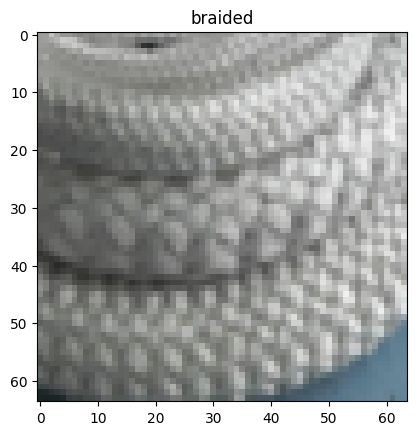

In [271]:
image, label = train_data[100]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose(1,2,0)
plt.imshow(image)
plt.title(classes[label])

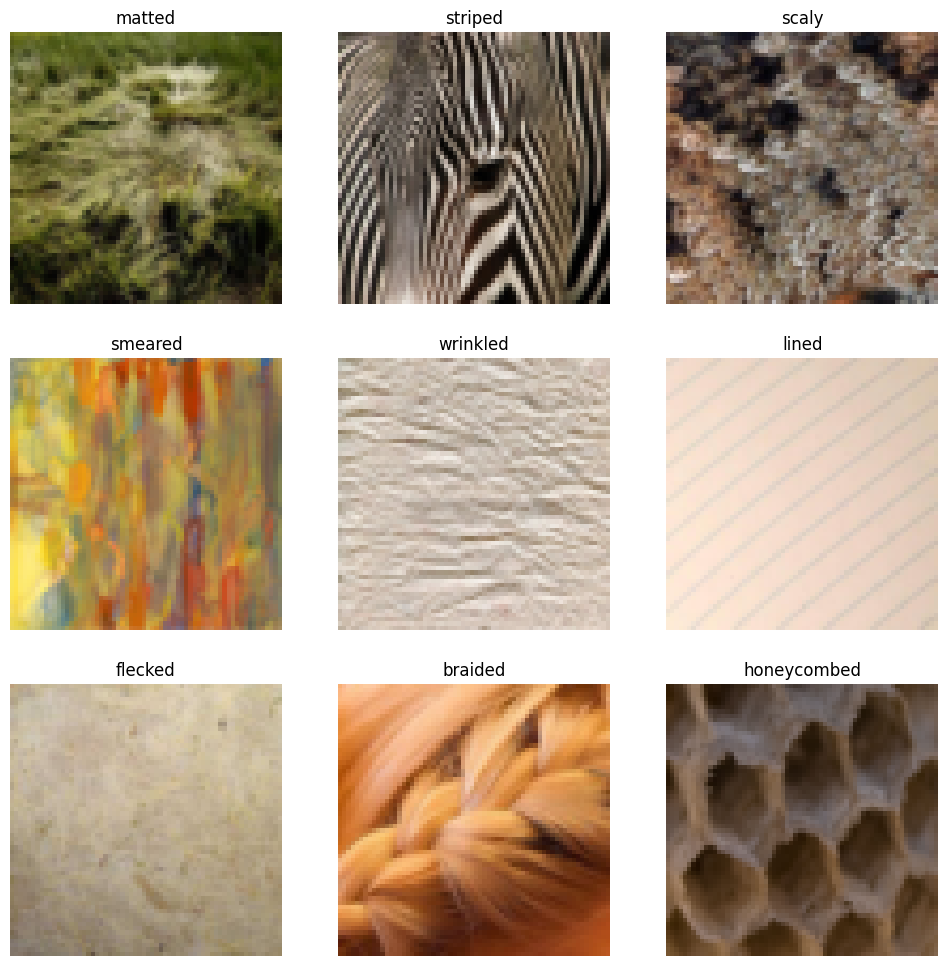

In [272]:
fig = plt.figure(figsize=(12,12))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[rand_idx]
  image = image.numpy()
  image = image.transpose(1,2,0)
  fig.add_subplot(rows, cols, i)
  plt.imshow(image)
  plt.title(classes[label])
  plt.axis(False)

In [273]:
BATCH_SIZE=16

In [274]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [275]:
class baseline_vision_classifier(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=4,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=4,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=4,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=4,
            stride=1,
            padding="same"
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*256,
            out_features=output_shape
        )
    )

  def forward(self, x):
    #print("First Layer")
    x = self.conv_block_1(x)
    #print(x.shape)
    #print("Second Layer")
    x = self.conv_block_2(x)
   #print(x.shape)
    #print("Classifier Layer")
    out = self.classifier(x)
    return out


In [276]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val_dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e976f83ecb0>, <torch.utils.data.dataloader.DataLoader object at 0x7e976f83e9e0>)
Length of train_dataloader: 118 batches of 16
Length of test_dataloader: 118 batches of 16
Length of val_dataloader: 118 batches of 16


In [277]:
def Accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [278]:
def print_training_time(
    start: float,
    end: float,
    device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time: .3f} seconds")

In [279]:
def train_loop(model: torch.nn.Module,
                epochs: int,
                loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.nn.Module,
                accuracy):
  print(f"Running: ", model.__class__.__name__)
  train_start_time = timer()
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(loader):
      X, y = X.to(device), y.to(device)
      model.train()
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc += Accuracy(y, y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_acc /= len(loader)
    train_loss /= len(loader)
    print(f"Processed {len(loader)} batches")
    print(f"Train Accuracy: {train_acc: .2f}%, Train Loss: {train_loss: .4f}")

  training_end_time = timer()
  total_time = print_training_time(start=train_start_time, end=training_end_time, device=str(next(model.parameters()).device))

In [289]:
def test_loop(model: torch.nn.Module,
                epochs: int,
                loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.nn.Module,
                accuracy):

  test_start_time = timer()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X_test, y_test in tqdm(loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += Accuracy(y_test, y_test.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc  /= len(test_dataloader)
    print(f"Test Accuracy: {test_acc: .2f}%, Test Loss: {test_loss: .4f}")
    test_end_time = timer()

    total_time = print_training_time(start=test_start_time, end=test_end_time, device=str(next(model.parameters()).device))

In [290]:
def eval_loop(model: torch.nn.Module,
                epochs: int,
                loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.nn.Module,
                accuracy):

  val_start_time = timer()
  eval_loss, eval_acc = 0, 0
  with torch.inference_mode():
    for X, y in tqdm(loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_pred = model(X)
      eval_loss += loss_fn(y_pred, y)
      eval_acc += Accuracy(y, y_pred.argmax(dim=1))

    eval_loss /= len(test_dataloader)
    eval_acc  /= len(test_dataloader)

    print(f"Eval Accuracy: {eval_acc: .2f}%, Eval Loss: {eval_loss: .4f}")
    val_end_time = timer()
    total_time = print_training_time(start=val_start_time, end=val_end_time, device=str(next(model.parameters()).device))

In [282]:
EPOCHS=50
INPUT_SHAPE=3
HIDDEN_UNITS=1024
OUTPUT_SHAPE=47
LEARNING_RATE=0.01

In [283]:
baseline = baseline_vision_classifier(
    input_shape=INPUT_SHAPE,
    hidden_units=HIDDEN_UNITS,
    output_shape=OUTPUT_SHAPE
).to(device)

In [284]:
baseline

baseline_vision_classifier(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 1024, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=47, bias=True)
  )
)

In [285]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline.parameters(), lr=LEARNING_RATE)

In [286]:
baseline_training = train_loop(model=baseline, epochs=EPOCHS, loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)

Running:  baseline_vision_classifier


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
Processed 118 batches
Train Accuracy:  1.91%, Train Loss:  3.8517
Epoch: 1
Processed 118 batches
Train Accuracy:  2.81%, Train Loss:  3.8374
Epoch: 2
Processed 118 batches
Train Accuracy:  4.08%, Train Loss:  3.8092
Epoch: 3
Processed 118 batches
Train Accuracy:  5.35%, Train Loss:  3.7683
Epoch: 4
Processed 118 batches
Train Accuracy:  6.89%, Train Loss:  3.7238
Epoch: 5
Processed 118 batches
Train Accuracy:  7.26%, Train Loss:  3.6784
Epoch: 6
Processed 118 batches
Train Accuracy:  9.00%, Train Loss:  3.6419
Epoch: 7
Processed 118 batches
Train Accuracy:  10.75%, Train Loss:  3.5658
Epoch: 8
Processed 118 batches
Train Accuracy:  11.92%, Train Loss:  3.4974
Epoch: 9
Processed 118 batches
Train Accuracy:  14.41%, Train Loss:  3.3800
Epoch: 10
Processed 118 batches
Train Accuracy:  19.12%, Train Loss:  3.2227
Epoch: 11
Processed 118 batches
Train Accuracy:  24.10%, Train Loss:  2.9436
Epoch: 12
Processed 118 batches
Train Accuracy:  32.52%, Train Loss:  2.6124
Epoch: 13
Proces